In [38]:
#Bibliotecas
import pandas as pd
import numpy as np
import shutil
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [39]:
#Arquivos e variaveis

input_file = "c:\\Users\\thgcn\\OneDrive\\Academico\\Financial-Reports-Impact\\data\\final_data.csv"

final_data = pd.read_csv(input_file)

In [40]:
final_data.describe()

,CD_CVM,Close,Return,event,return_week,return_month,Year
count,3225.0,3225.000000,3224.000000,3225.000000,615.000000,112.000000,3225.000000
mean,19348.0,22.555047,0.000097,0.014884,0.000946,-0.001159,2016.007442
std,0.0,6.869489,0.020068,0.121106,0.038401,0.080957,3.740987
min,19348.0,11.633995,-0.198015,0.000000,-0.153768,-0.291205,2010.000000
25%,19348.0,16.515150,-0.011279,0.000000,-0.023243,-0.055503,2013.000000
50%,19348.0,21.200001,0.000000,0.000000,0.001031,0.000773,2016.000000
75%,19348.0,27.673332,0.010992,0.000000,0.023772,0.050451,2019.000000
max,19348.0,39.689999,0.111276,1.000000,0.190721,0.253973,2022.000000


In [37]:
final_data

,CD_CVM,Close,Date,Return,event,return_week,return_month,Year
0,19348,18.268333,2010-01-04,NaN,0,NaN,NaN,2010
1,19348,18.386723,2010-01-05,0.006460,0,NaN,NaN,2010
2,19348,18.227352,2010-01-06,-0.008706,0,NaN,NaN,2010
3,19348,18.040663,2010-01-07,-0.010295,0,NaN,NaN,2010
4,19348,17.767456,2010-01-08,-0.015260,0,-0.027801,NaN,2010
...,...,...,...,...,...,...,...,...
3220,19348,25.190001,2022-12-23,0.015604,0,NaN,NaN,2022
3221,19348,24.690001,2022-12-26,-0.020049,0,NaN,NaN,2022
3222,19348,24.549999,2022-12-27,-0.005687,0,NaN,NaN,2022
3223,19348,25.049999,2022-12-28,0.020162,0,NaN,NaN,2022


In [296]:
# NÃO EXECUTAR Gera os dataframes de retorno mensal e semanal com INDEX
def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan

    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o próximo evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break

        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 4 < len(final_data):
            final_data.loc[event_idx + 4, 'return_week'] = np.log(final_data.loc[event_idx + 4, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 4])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 5, len(final_data), 7):
            if i + 6 < len(final_data) and final_data.loc[i, 'event'] != 1:
                final_data.loc[i + 6, 'return_week'] = np.log(final_data.loc[i + 6, 'Close'] / final_data.loc[i, 'Close'])
                remaining_return_week_list.append(final_data.iloc[i + 6])
            elif i + 6 >= len(final_data):
                break

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < len(final_data):
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 22, len(final_data), 22):
            if i + 21 < len(final_data) and final_data.loc[i, 'event'] != 1:
                final_data.loc[i + 21, 'return_month'] = np.log(final_data.loc[i + 21, 'Close'] / final_data.loc[i, 'Close'])
                remaining_return_month_list.append(final_data.iloc[i + 21])
            elif i + 21 >= len(final_data):
                break

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()
    
    return first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df

# Exemplo de uso com um DataFrame
# final_data = pd.read_csv('path_to_your_file.csv')  # Carregar os dados

# Aplicar a função ao DataFrame
first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)


In [26]:
#Cálculo do próximo retorno
# Garantir que a coluna 'event' seja do tipo string
final_data['event'] = final_data['event'].astype(str)

# Filtra as linhas onde o valor da coluna 'event' é igual a '1'
filtered_data = final_data[final_data['event'].str.strip() == '1']

# Adiciona uma coluna chamada 'next_value' que contém o valor da próxima linha de 'data'
filtered_data['nxt_return'] = final_data['Return'].shift(-1)

# Limpar as linhas que contem null:
#final_data = final_data.dropna()
#filtered_data = filtered_data.dropna()
#first_return = filtered_data['nxt_return'].dropna()
#returns = final_data['Return'].dropna()

<ipython-input-26-8ba5acfa8067>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['nxt_return'] = final_data['Return'].shift(-1)


In [35]:
# Separa em dataframes de semanas

import pandas as pd
import numpy as np

def calculate_returns_week(df):
    df['return_week'] = np.nan
    first_return_week_list = []
    remaining_return_week_list = []
    
    start_idx = 0
    while start_idx < len(df):
        # Encontra o próximo evento
        event_idx = df[start_idx:]['event'].eq(1).idxmax() if 1 in df[start_idx:]['event'].values else len(df)
        
        # Divide o intervalo entre start_idx e event_idx em segmentos de 5 dias
        first_return_added = False
        for i in range(start_idx, event_idx, 5):
            if i + 4 < event_idx:
                # Calcular o log-retorno semanal
                log_return = np.log(df.loc[i + 4, 'Close'] / df.loc[i, 'Close'])
                df.loc[i + 4, 'return_week'] = log_return
                
                # Adicionar ao DataFrame apropriado
                if not first_return_added:
                    first_return_week_list.append({'index': i + 4, 'return_week': log_return})
                    first_return_added = True
                else:
                    remaining_return_week_list.append({'index': i + 4, 'return_week': log_return})
        
        # Reinicia após o evento
        start_idx = event_idx + 1
    
    # Convertendo listas de dicionários em DataFrames
    first_return_week_df = pd.DataFrame(first_return_week_list).set_index('index')
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).set_index('index')
    
    return df, first_return_week_df, remaining_return_week_df

# Exemplo de uso

# Calculando os retornos
final_data, first_return_week_df, remaining_return_week_df = calculate_returns_week(final_data)

In [36]:
# Separa em dataframes de meses

def calculate_returns_month(df):
    df['return_month'] = np.nan
    first_return_month_list = []
    remaining_return_month_list = []
    
    start_idx = 0
    while start_idx < len(df):
        # Encontra o próximo evento
        event_idx = df[start_idx:]['event'].eq(1).idxmax() if 1 in df[start_idx:]['event'].values else len(df)
        
        # Divide o intervalo entre start_idx e event_idx em segmentos de 22 dias
        first_return_added = False
        for i in range(start_idx, event_idx, 22):
            if i + 21 < event_idx:
                # Calcular o log-retorno mensal
                log_return = np.log(df.loc[i + 21, 'Close'] / df.loc[i, 'Close'])
                df.loc[i + 21, 'return_month'] = log_return
                
                # Adicionar ao DataFrame apropriado
                if not first_return_added:
                    first_return_month_list.append({'index': i + 21, 'return_month': log_return})
                    first_return_added = True
                else:
                    remaining_return_month_list.append({'index': i + 21, 'return_month': log_return})
        
        # Reinicia após o evento
        start_idx = event_idx + 1
    
    # Convertendo listas de dicionários em DataFrames
    first_return_month_df = pd.DataFrame(first_return_month_list).set_index('index')
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).set_index('index')
    
    return df, first_return_month_df, remaining_return_month_df


# Calculando os retornos
final_data, first_return_month_df, remaining_return_month_df = calculate_returns_month(final_data)

In [5]:
def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan
        
    first_return_daily_list = []
    remaining_return_daily_list = []
    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break
        # Encontrar o próximo evento
        if 1 in final_data[event_idx+1:]['event'].values:
            prox_event_idx = final_data[event_idx+1:]['event'].eq(1).idxmax()
        else:
            prox_event_idx = len(final_data)
            
        # Calcular o primeiro retorno diario logo após o evento
        if event_idx + 1 < len(final_data):
            final_data.loc[event_idx + 1, 'return_week'] = np.log(final_data.loc[event_idx + 1, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_daily_list.append(final_data.iloc[event_idx + 1])

        # Calcular os retornos diarios restantes até o próximo evento
        for i in range(event_idx + 2, prox_event_idx, 1):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-1, 'Close'])
            remaining_return_daily_list.append(final_data.iloc[i])
                
        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 5 < len(final_data):
            final_data.loc[event_idx + 5, 'return_week'] = np.log(final_data.loc[event_idx + 5, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 5])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 10, prox_event_idx, 5):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-5, 'Close'])
            remaining_return_week_list.append(final_data.iloc[i])
        

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < prox_event_idx:
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 42, prox_event_idx, 22):
            final_data.loc[i, 'return_month'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-21, 'Close'])
            remaining_return_month_list.append(final_data.iloc[i + 21])

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_daily_df = pd.DataFrame(first_return_daily_list).reset_index()
    remaining_return_daily_df = pd.DataFrame(remaining_return_daily_list).reset_index()
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()
    
    return first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df

# Exemplo de uso com um DataFrame
# final_data = pd.read_csv('path_to_your_file.csv')  # Carregar os dados

# Aplicar a função ao DataFrame
first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)

In [29]:
# Carrega os datasets
# Retornos diarios
nxt_return = filtered_data['nxt_return'].dropna()
Returns = final_data['Return'].dropna()
#Retornos semanais
first_return_week = first_return_week_df["return_week"]
remaining_return_week = remaining_return_week_df["return_week"]
#Retornos mensais
first_return_month = first_return_month_df["return_month"]
remaining_return_month = remaining_return_month_df["return_month"]

In [31]:
import pandas as pd

# Supondo que os DataFrames já estejam carregados ou calculados
# Return = pd.Series(...)
# nxt_return = pd.Series(...)
# first_return_week = pd.Series(...)
# remaining_return_week = pd.Series(...)
# first_return_month = pd.Series(...)
# remaining_return_month = pd.Series(...)

# Crie um DataFrame único combinando todos os DataFrames em colunas diferentes
combined_df = pd.concat([Returns, nxt_return, first_return_week, remaining_return_week, first_return_month, remaining_return_month], axis=1)

# Renomeie as colunas para os nomes dos DataFrames
combined_df.columns = ['Returns', 'nxt_return', 'first_return_week', 'remaining_return_week', 'first_return_month', 'remaining_return_month']

# Salve o DataFrame combinado em um único arquivo CSV
combined_df.to_csv('retornos_finais.csv', index=False)

print("DataFrames salvos com sucesso no arquivo retornos_finais.csv")


DataFrames salvos com sucesso no arquivo retornos_finais.csv


In [32]:
pd.DataFrame(remaining_return_month_df, columns=['remaining_return_week']).describe()

,remaining_return_week
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [33]:
# Analise se tem linhas duplicadas

def find_duplicates(df):
    # Identifica todas as linhas duplicadas (incluindo a primeira ocorrência)
    duplicates = df[df.duplicated(keep=False)]
    
    # Conta o número de linhas duplicadas (excluindo a primeira ocorrência)
    num_duplicates = len(df[df.duplicated()])
    
    # Agrupa as duplicatas e lista seus índices
    duplicate_indices = duplicates.groupby(list(df.columns)).apply(lambda x: list(x.index))

    return num_duplicates, duplicate_indices

num_duplicates, duplicate_indices = find_duplicates(filtered_data)
print(f"Number of duplicate lines: {num_duplicates}")
print("Duplicate indices:")
print(duplicate_indices)


Number of duplicate lines: 0
Duplicate indices:
Empty DataFrame
Columns: []
Index: []


In [34]:
import pandas as pd

# Supondo que os dados estejam em um DataFrame chamado df com as colunas correspondentes
data = {
    'Returns': Returns,
    'nxt_return': nxt_return,
    'remaining_return_week': remaining_return_week,
    'first_return_week': first_return_week,
    'remaining_return_month': remaining_return_month,
    'first_return_month': first_return_month
}

# Criação do DataFrame
df = pd.DataFrame(data)

# Descrição estatística dos dados
description = df.describe()

# Exibindo a descrição estatística
print(description)


           Returns  nxt_return  remaining_return_week  first_return_week  \
count  3224.000000   48.000000             644.000000           1.000000   
mean      0.000097   -0.000234              -0.000279          -0.027801   
std       0.020068    0.025381               0.038702                NaN   
min      -0.198015   -0.060625              -0.154427          -0.027801   
25%      -0.011279   -0.014663              -0.024639          -0.027801   
50%       0.000000   -0.001989               0.000312          -0.027801   
75%       0.010992    0.022919               0.023118          -0.027801   
max       0.111276    0.040834               0.210465          -0.027801   

       remaining_return_month  first_return_month  
count              145.000000             1.00000  
mean                 0.003057            -0.07718  
std                  0.084595                 NaN  
min                 -0.291205            -0.07718  
25%                 -0.046754            -0.07718  
50%

In [325]:
remaining_return_week  

index
9      -0.037134
14     -0.036565
19      0.012851
24     -0.072254
29      0.043984
          ...   
3201   -0.029346
3206   -0.007018
3211   -0.081637
3216    0.050452
3221    0.001621
Name: return_week, Length: 566, dtype: float64

In [22]:
filtered_data['nxt_return'].describe()

count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64


Comparação de Retornos Diários:


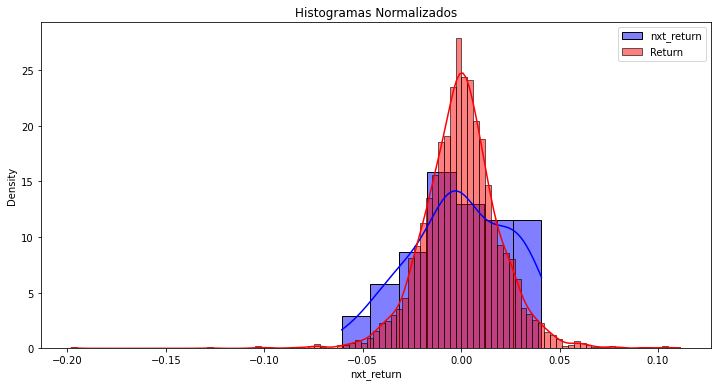

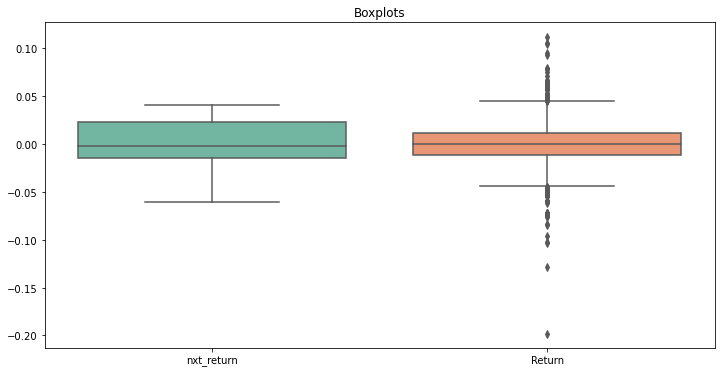

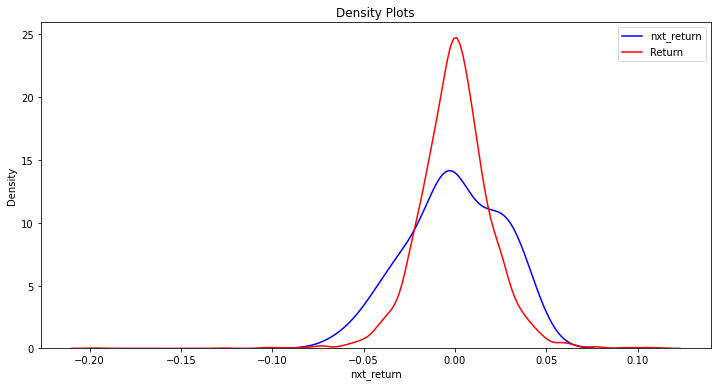

Estatísticas Descritivas:
nxt_return
count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

Return
count    3224.000000
mean        0.000097
std         0.020068
min        -0.198015
25%        -0.011279
50%         0.000000
75%         0.010992
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=77646.0, p-value=0.9669116494199598

Kolmogorov-Smirnov Test: KS-stat=0.17318031430934658, p-value=0.1036904996425645

Levene Test: stat=7.586491903037072, p-value=0.005913261739923997

Bootstrap mean 95% CI for nxt_return: [-0.00765019  0.00744943]
Bootstrap median 95% CI for nxt_return: [-0.00486375  0.00919087]
Bootstrap mean 95% CI for Return: [-0.00060329  0.00078166]
Bootstrap median 95% CI for Return: [-0.00036001  0.00052873]

Importâncias das Características: [1.]
ROC AUC Score: 0.9925526002894954

Comparação de Retornos Semanais

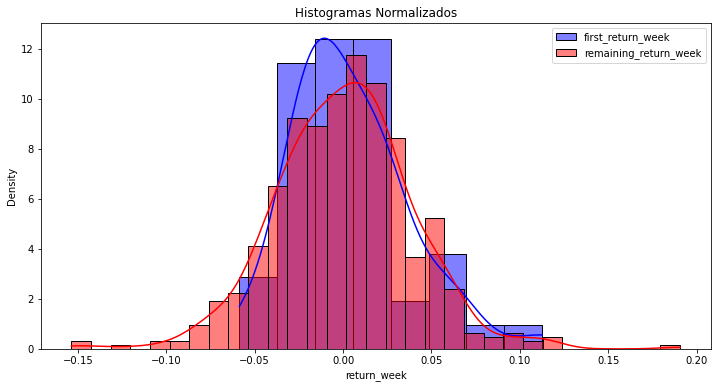

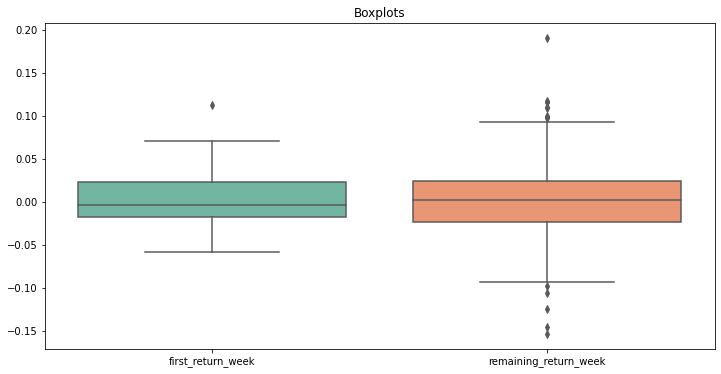

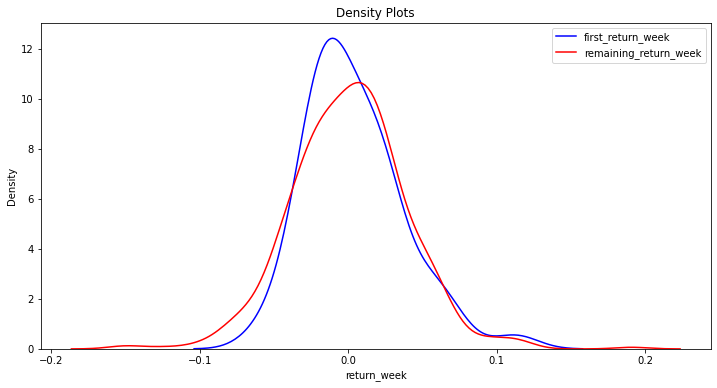

Estatísticas Descritivas:
first_return_week
count    49.000000
mean      0.004066
std       0.032834
min      -0.058684
25%      -0.017328
50%      -0.003335
75%       0.023134
max       0.112603
Name: return_week, dtype: float64

remaining_return_week
count    566.000000
mean       0.000676
std        0.038859
min       -0.153768
25%       -0.023454
50%        0.001538
75%        0.023890
max        0.190721
Name: return_week, dtype: float64

Mann-Whitney U Test: U-stat=14195.0, p-value=0.7837183858474396

Kolmogorov-Smirnov Test: KS-stat=0.11801399004831614, p-value=0.5156265175125667

Levene Test: stat=1.687124083602122, p-value=0.19446887256000542

Bootstrap mean 95% CI for first_return_week: [-0.00523338  0.01294864]
Bootstrap median 95% CI for first_return_week: [-0.01223678  0.0127647 ]
Bootstrap mean 95% CI for remaining_return_week: [-0.00240691  0.00376604]
Bootstrap median 95% CI for remaining_return_week: [-0.00360366  0.00522999]

Importâncias das Características: [1.]
ROC

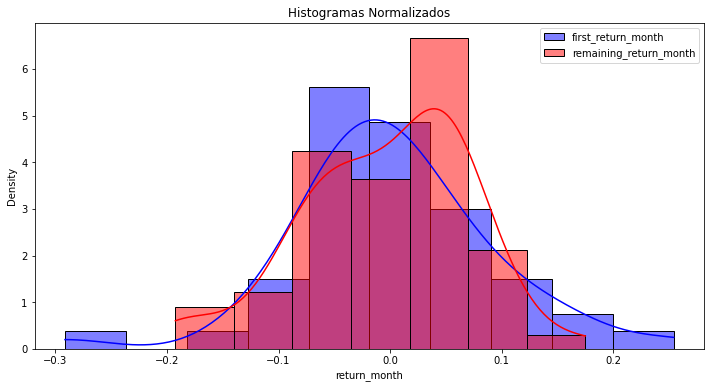

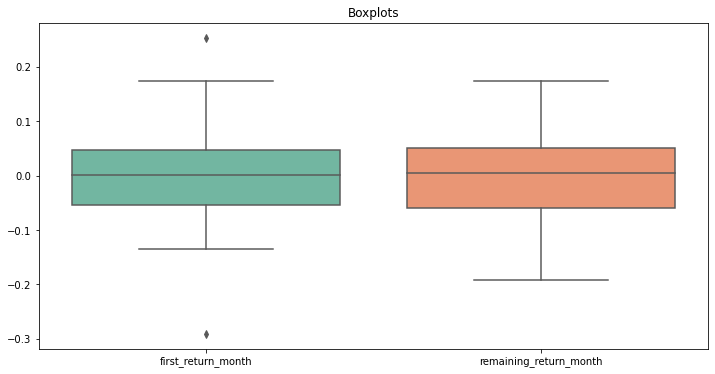

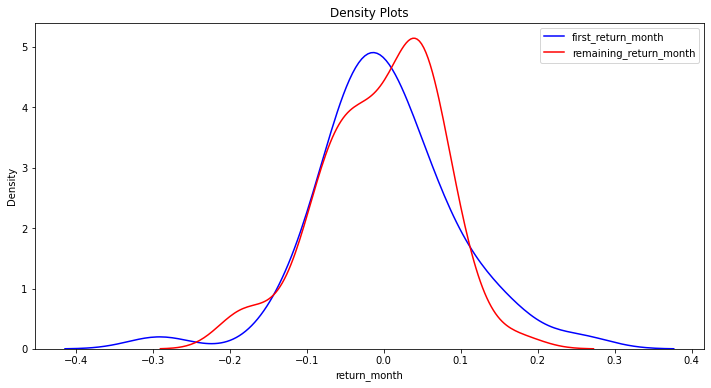

Estatísticas Descritivas:
first_return_month
count    49.000000
mean      0.001440
std       0.089163
min      -0.291205
25%      -0.053400
50%       0.000543
75%       0.047211
max       0.253973
Name: return_month, dtype: float64

remaining_return_month
count    63.000000
mean     -0.003180
std       0.074629
min      -0.192372
25%      -0.059687
50%       0.004388
75%       0.050746
max       0.174773
Name: return_month, dtype: float64

Mann-Whitney U Test: U-stat=1544.0, p-value=1.0

Kolmogorov-Smirnov Test: KS-stat=0.14512471655328799, p-value=0.5528919822021797

Levene Test: stat=0.11047390348899294, p-value=0.7402377940992834

Bootstrap mean 95% CI for first_return_month: [-0.02345696  0.02706649]
Bootstrap median 95% CI for first_return_month: [-0.03194729  0.01392836]
Bootstrap mean 95% CI for remaining_return_month: [-0.02222674  0.01388193]
Bootstrap median 95% CI for remaining_return_month: [-0.02521148  0.03584849]

Importâncias das Características: [1.]
ROC AUC Score: 0.9

In [326]:
# Criação dos histogramas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Função para exibir visualizações e testes estatísticos
def analyze_returns(return_1, return_2, label_1, label_2):
    # 1. Visualização
    # Histogramas normalizados
    plt.figure(figsize=(12, 6))
    sns.histplot(return_1, kde=True, stat='density', label=label_1, color='blue')
    sns.histplot(return_2, kde=True, stat='density', label=label_2, color='red')
    plt.legend()
    plt.title('Histogramas Normalizados')
    plt.show()

    # Boxplots
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[return_1, return_2], palette='Set2')
    plt.xticks([0, 1], [label_1, label_2])
    plt.title('Boxplots')
    plt.show()

    # Density Plot (KDE)
    plt.figure(figsize=(12, 6))
    sns.kdeplot(return_1, label=label_1, color='blue')
    sns.kdeplot(return_2, label=label_2, color='red')
    plt.legend()
    plt.title('Density Plots')
    plt.show()

    # 2. Estatísticas Descritivas
    print("Estatísticas Descritivas:")
    print(label_1)
    print(return_1.describe())
    print(f"\n{label_2}")
    print(return_2.describe())

    # 3. Testes de Hipóteses
    # Teste U de Mann-Whitney
    u_stat, p_value = stats.mannwhitneyu(return_1, return_2)
    print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

    # Teste de Kolmogorov-Smirnov
    ks_stat, p_value = stats.ks_2samp(return_1, return_2)
    print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

    # Teste de Levene para variâncias
    levene_stat, p_value = stats.levene(return_1, return_2)
    print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

    # 4. Reamostragem
    # Bootstrapping para média e mediana
    bootstrap_means_1 = []
    bootstrap_medians_1 = []
    bootstrap_means_2 = []
    bootstrap_medians_2 = []

    for _ in range(1000):
        sample_1 = resample(return_1, replace=True)
        sample_2 = resample(return_2, replace=True)
        bootstrap_means_1.append(np.mean(sample_1))
        bootstrap_medians_1.append(np.median(sample_1))
        bootstrap_means_2.append(np.mean(sample_2))
        bootstrap_medians_2.append(np.median(sample_2))

    print(f"\nBootstrap mean 95% CI for {label_1}: {np.percentile(bootstrap_means_1, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_1}: {np.percentile(bootstrap_medians_1, [2.5, 97.5])}")
    print(f"Bootstrap mean 95% CI for {label_2}: {np.percentile(bootstrap_means_2, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_2}: {np.percentile(bootstrap_medians_2, [2.5, 97.5])}")

    # Balanceamento de amostras
    balanced_1 = resample(return_1, n_samples=len(return_2), random_state=42)

    # 5. Machine Learning
    # Preparar os dados para o modelo
    X = np.concatenate([return_1.values.reshape(-1, 1), return_2.values.reshape(-1, 1)])
    y = np.concatenate([np.zeros(len(return_1)), np.ones(len(return_2))])

    # Treinar o modelo de Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    # Avaliar a importância das características
    feature_importances = rf.feature_importances_
    print(f"\nImportâncias das Características: {feature_importances}")

    # Avaliar o modelo
    roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")

# Função principal
def main():
    # Retornos diários
    daily_return_1 = filtered_data['nxt_return'].dropna()
    daily_return_2 = final_data['Return'].dropna()

    # Retornos semanais
    first_return_week = first_return_week_df['return_week'].dropna()
    remaining_return_week = remaining_return_week_df['return_week'].dropna()

    # Retornos mensais
    first_return_month = first_return_month_df['return_month'].dropna()
    remaining_return_month = remaining_return_month_df['return_month'].dropna()

    # Analisar retornos diários
    print("\nComparação de Retornos Diários:")
    analyze_returns(daily_return_1, daily_return_2, 'nxt_return', 'Return')

    # Analisar retornos semanais
    print("\nComparação de Retornos Semanais:")
    analyze_returns(first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')

    # Analisar retornos mensais
    print("\nComparação de Retornos Mensais:")
    analyze_returns(first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')

# Executar a função principal
main()


In [ ]:


# 1. Visualização
# Histogramas normalizados
plt.figure(figsize=(12, 6))
sns.histplot(nxt_return, kde=True, stat='density', label='nxt_return', color='blue')
sns.histplot(Return, kde=True, stat='density', label='Return', color='red')
plt.legend()
plt.title('Histogramas Normalizados')
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[nxt_return, Return], palette='Set2')
plt.xticks([0, 1], ['nxt_return', 'Return'])
plt.title('Boxplots')
plt.show()

# Density Plot (KDE)
plt.figure(figsize=(12, 6))
sns.kdeplot(nxt_return, label='nxt_return', color='blue')
sns.kdeplot(Return, label='Return', color='red')
plt.legend()
plt.title('Density Plots')
plt.show()

# 2. Estatísticas Descritivas
print("Estatísticas Descritivas:")
print("nxt_return")
print(nxt_return.describe())
print("\nReturn")
print(Return.describe())

# 3. Testes de Hipóteses
# Teste U de Mann-Whitney
u_stat, p_value = stats.mannwhitneyu(nxt_return, Return)
print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

# Teste de Kolmogorov-Smirnov
ks_stat, p_value = stats.ks_2samp(nxt_return, Return)
print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

# Teste de Levene para variâncias
levene_stat, p_value = stats.levene(nxt_return, Return)
print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

# 4. Reamostragem
# Bootstrapping para média e mediana
bootstrap_means_nxt_return = []
bootstrap_medians_nxt_return = []
bootstrap_means_Return = []
bootstrap_medians_Return = []

for _ in range(1000):
    sample_nxt_return = resample(nxt_return, replace=True)
    sample_Return = resample(Return, replace=True)
    bootstrap_means_nxt_return.append(np.mean(sample_nxt_return))
    bootstrap_medians_nxt_return.append(np.median(sample_nxt_return))
    bootstrap_means_Return.append(np.mean(sample_Return))
    bootstrap_medians_Return.append(np.median(sample_Return))

print(f"\nBootstrap mean 95% CI for nxt_return: {np.percentile(bootstrap_means_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for nxt_return: {np.percentile(bootstrap_medians_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap mean 95% CI for Return: {np.percentile(bootstrap_means_Return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for Return: {np.percentile(bootstrap_medians_Return, [2.5, 97.5])}")

# Balanceamento de amostras
balanced_nxt_return = resample(nxt_return, n_samples=len(Return), random_state=42)

# 5. Machine Learning
# Preparar os dados para o modelo
X = np.concatenate([nxt_return.values.reshape(-1, 1), Return.values.reshape(-1, 1)])
y = np.concatenate([np.zeros(len(nxt_return)), np.ones(len(Return))])

# Treinar o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Avaliar a importância das características
feature_importances = rf.feature_importances_
print(f"\nImportâncias das Características: {feature_importances}")

# Avaliar o modelo
roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
print(f"ROC AUC Score: {roc_auc}")


In [ ]:
# Supondo que filtered_data e new_final_data são DataFrames já carregados
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']

# 1. Teste de Shapiro-Wilk
shapiro_nxt_return = stats.shapiro(nxt_return)
shapiro_Return = stats.shapiro(Return)
print(f"Shapiro-Wilk Test for nxt_return: W-stat={shapiro_nxt_return[0]}, p-value={shapiro_nxt_return[1]}")
print(f"Shapiro-Wilk Test for Return: W-stat={shapiro_Return[0]}, p-value={shapiro_Return[1]}")

# 2. Teste de Kolmogorov-Smirnov
ks_stat, ks_p_value = stats.ks_2samp(nxt_return, Return)
print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

# 3. Teste F de Levene
levene_stat, levene_p_value = stats.levene(nxt_return, Return)
print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

# 4. Teste de Chow
# Criar DataFrame combinando as amostras com uma coluna indicadora
data = pd.DataFrame({'returns': np.concatenate([nxt_return, Return]), 
                     'group': ['nxt_return'] * len(nxt_return) + ['Return'] * len(Return)})

# Modelo completo (inclui interação)
model_full = smf.ols('returns ~ group', data=data).fit()
RSS_full = sum(model_full.resid ** 2)
df_full = model_full.df_resid

# Modelos separados
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
RSS_nxt_return = sum(model_nxt_return.resid ** 2)
RSS_Return = sum(model_Return.resid ** 2)
RSS_combined = RSS_nxt_return + RSS_Return
df_combined = model_nxt_return.df_resid + model_Return.df_resid

# Teste de Chow
chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

# 5. Teste t de Student
t_stat, t_p_value = stats.ttest_ind(nxt_return, Return, equal_var=False)
print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")


In [10]:
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
model_full = smf.ols('returns ~ group', data=data).fit()

In [327]:
# Testes estatisiticos
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

def perform_tests(filtered_data, final_data, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df):
    # Obter os retornos necessários
    nxt_return = filtered_data['nxt_return'].dropna()
    Return = final_data['Return'].dropna()

    first_return_week = first_return_week_df['return_week'].dropna()
    remaining_return_week = remaining_return_week_df['return_week'].dropna()

    first_return_month = first_return_month_df['return_month'].dropna()
    remaining_return_month = remaining_return_month_df['return_month'].dropna()

    # Lista de pares para análise
    return_pairs = [
        ('nxt_return', nxt_return, 'Return', Return),
        ('first_return_week', first_return_week, 'remaining_return_week', remaining_return_week),
        ('first_return_month', first_return_month, 'remaining_return_month', remaining_return_month)
    ]

    for label1, return1, label2, return2 in return_pairs:
        print(f"\nAnalisando {label1} vs {label2}")

        # 1. Teste de Shapiro-Wilk
        shapiro_return1 = stats.shapiro(return1)
        shapiro_return2 = stats.shapiro(return2)
        print(f"Shapiro-Wilk Test for {label1}: W-stat={shapiro_return1[0]}, p-value={shapiro_return1[1]}")
        print(f"Shapiro-Wilk Test for {label2}: W-stat={shapiro_return2[0]}, p-value={shapiro_return2[1]}")

        # 2. Teste de Kolmogorov-Smirnov
        ks_stat, ks_p_value = stats.ks_2samp(return1, return2)
        print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

        # 3. Teste F de Levene
        levene_stat, levene_p_value = stats.levene(return1, return2)
        print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

        # 4. Teste de Chow
        # Criar DataFrame combinando as amostras com uma coluna indicadora
        data = pd.DataFrame({'returns': np.concatenate([return1, return2]), 
                             'group': [label1] * len(return1) + [label2] * len(return2)})

        # Modelo completo (inclui interação)
        model_full = smf.ols('returns ~ group', data=data).fit()
        RSS_full = sum(model_full.resid ** 2)
        df_full = model_full.df_resid

        # Modelos separados
        model_return1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
        model_return2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
        RSS_return1 = sum(model_return1.resid ** 2)
        RSS_return2 = sum(model_return2.resid ** 2)
        RSS_combined = RSS_return1 + RSS_return2
        df_combined = model_return1.df_resid + model_return2.df_resid

        # Teste de Chow
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
        print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

        # 5. Teste t de Student
        t_stat, t_p_value = stats.ttest_ind(return1, return2, equal_var=False)
        print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")

# Supondo que filtered_data e final_data são DataFrames já carregados
# Além dos DataFrames first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df
perform_tests(filtered_data, final_data, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df)



Analisando nxt_return vs Return
Shapiro-Wilk Test for nxt_return: W-stat=0.9673745632171631, p-value=0.19974040985107422
Shapiro-Wilk Test for Return: W-stat=0.9611008167266846, p-value=1.3548705306470322e-28
Kolmogorov-Smirnov Test: KS-stat=0.17318031430934658, p-value=0.1036904996425645
Levene Test: stat=7.586491903037072, p-value=0.005913261739923997
Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=-0.09010147755071753, p-value=0.9285824516722296

Analisando first_return_week vs remaining_return_week
Shapiro-Wilk Test for first_return_week: W-stat=0.9498617649078369, p-value=0.03645922243595123
Shapiro-Wilk Test for remaining_return_week: W-stat=0.9865394830703735, p-value=4.408790118759498e-05
Kolmogorov-Smirnov Test: KS-stat=0.11801399004831614, p-value=0.5156265175125667
Levene Test: stat=1.687124083602122, p-value=0.19446887256000542
Chow Test: F-stat=inf, p-value=nan
Student's t-test: t-stat=0.6825519116450695, p-value=0.497505096963869

Analisando first_return_mon

<ipython-input-327-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-327-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-327-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


Vamos analisar os resultados fornecidos para cada par de variáveis e entender o que cada teste estatístico indica.

### Análise de `nxt_return` vs `Return`

1. **Shapiro-Wilk Test**:
    - **nxt_return**: \( W = 0.967 \), \( p = 0.200 \)
    - **Return**: \( W = 0.961 \), \( p = 1.355 \times 10^{-28} \)
    - **Interpretação**: O teste Shapiro-Wilk avalia a normalidade dos dados. Para `nxt_return`, o p-valor é maior que 0.05, indicando que não há evidência suficiente para rejeitar a normalidade. Para `Return`, o p-valor é extremamente pequeno, indicando que os dados não são normalmente distribuídos.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.173 \), \( p = 0.104 \)
    - **Interpretação**: Este teste compara as distribuições cumulativas das duas amostras. Com um p-valor de 0.104, não há evidência suficiente para rejeitar a hipótese de que `nxt_return` e `Return` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 7.586 \), \( p = 0.006 \)
    - **Interpretação**: O teste de Levene avalia a igualdade das variâncias. Com um p-valor menor que 0.05, há evidência de que as variâncias de `nxt_return` e `Return` são significativamente diferentes.

4. **Chow Test**:
    - **F-stat**: \(-\infty\), \( p = \text{nan} \)
    - **Interpretação**: O teste de Chow é usado para testar a estabilidade dos coeficientes de regressão em diferentes sub-amostras. Os resultados indicam problemas com o cálculo, possivelmente devido à divisão por zero, tornando o resultado inválido.

5. **Student's t-test**:
    - **t-stat**: \(-0.090\), \( p = 0.929 \)
    - **Interpretação**: O teste t avalia se as médias de duas amostras são significativamente diferentes. Com um p-valor de 0.929, não há evidência suficiente para rejeitar a hipótese de que as médias de `nxt_return` e `Return` são iguais.

### Análise de `first_return_week` vs `remaining_return_week`

1. **Shapiro-Wilk Test**:
    - **first_return_week**: \( W = 0.950 \), \( p = 0.036 \)
    - **remaining_return_week**: \( W = 0.987 \), \( p = 4.409 \times 10^{-5} \)
    - **Interpretação**: Para ambas as variáveis, os p-valores são menores que 0.05, indicando que nenhuma das duas distribuições é normalmente distribuída.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.118 \), \( p = 0.516 \)
    - **Interpretação**: Com um p-valor de 0.516, não há evidência suficiente para rejeitar a hipótese de que `first_return_week` e `remaining_return_week` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 1.687 \), \( p = 0.194 \)
    - **Interpretação**: Com um p-valor de 0.194, não há evidência suficiente para rejeitar a hipótese de que as variâncias de `first_return_week` e `remaining_return_week` são iguais.

4. **Chow Test**:
    - **F-stat**: \(\infty\), \( p = \text{nan} \)
    - **Interpretação**: Como anteriormente, o teste de Chow mostra resultados inválidos devido a problemas de cálculo.

5. **Student's t-test**:
    - **t-stat**: \( 0.683 \), \( p = 0.498 \)
    - **Interpretação**: Com um p-valor de 0.498, não há evidência suficiente para rejeitar a hipótese de que as médias de `first_return_week` e `remaining_return_week` são iguais.

### Análise de `first_return_month` vs `remaining_return_month`

1. **Shapiro-Wilk Test**:
    - **first_return_month**: \( W = 0.960 \), \( p = 0.096 \)
    - **remaining_return_month**: \( W = 0.972 \), \( p = 0.167 \)
    - **Interpretação**: Para ambas as variáveis, os p-valores são maiores que 0.05, indicando que não há evidência suficiente para rejeitar a normalidade das distribuições.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.145 \), \( p = 0.553 \)
    - **Interpretação**: Com um p-valor de 0.553, não há evidência suficiente para rejeitar a hipótese de que `first_return_month` e `remaining_return_month` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 0.110 \), \( p = 0.740 \)
    - **Interpretação**: Com um p-valor de 0.740, não há evidência suficiente para rejeitar a hipótese de que as variâncias de `first_return_month` e `remaining_return_month` são iguais.

4. **Chow Test**:
    - **F-stat**: \(\infty\), \( p = \text{nan} \)
    - **Interpretação**: Novamente, o teste de Chow mostra resultados inválidos devido a problemas de cálculo.

5. **Student's t-test**:
    - **t-stat**: \( 0.292 \), \( p = 0.771 \)
    - **Interpretação**: Com um p-valor de 0.771, não há evidência suficiente para rejeitar a hipótese de que as médias de `first_return_month` e `remaining_return_month` são iguais.

### Resumo:

- **Normalidade**: `nxt_return` e `first_return_month` parecem ser normalmente distribuídos, enquanto `Return`, `first_return_week`, e `remaining_return_week` não são.
- **Distribuições Iguais**: `Kolmogorov-Smirnov Test` sugere que as distribuições de `nxt_return` vs `Return`, `first_return_week` vs `remaining_return_week`, e `first_return_month` vs `remaining_return_month` não são significativamente diferentes.
- **Igualdade de Variâncias**: O `Levene Test` indica que `nxt_return` e `Return` têm variâncias diferentes, enquanto as outras comparações não têm variâncias significativamente diferentes.
- **Igualdade de Médias**: O `Student's t-test` sugere que as médias de `nxt_return` vs `Return`, `first_return_week` vs `remaining_return_week`, e `first_return_month` vs `remaining_return_month` não são significativamente diferentes.

### Considerações Adicionais:
- Os problemas com o `Chow Test` precisam ser investigados e corrigidos para obter resultados válidos.
- A análise sugere que os retornos mensais podem ter propriedades estatísticas diferentes dos retornos semanais, especialmente em termos de normalidade e variância.

In [169]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from tabulate import tabulate

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    try:
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    except ZeroDivisionError:
        chow_stat = float('inf')
        chow_p_value = float('nan')

    results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Função para realizar a análise completa
def analyze_groups(tests):
    results = {}
    for label1, label2, group1, group2 in tests:
        key = f'{label1} vs {label2}'
        results[key] = perform_tests(group1, group2, label1, label2)

    # Convertendo os resultados em DataFrame para exibição
    columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
    data = []
    for key, value in results.items():
        for test, result in value.items():
            row = [test] + result
            row.insert(0, key)
            data.append(row)

    results_df = pd.DataFrame(data, columns=['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2'])

    # Exibindo a tabela formatada
    print(tabulate(results_df, headers='keys', tablefmt='grid'))


# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
    ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month),
]

# Analisando os grupos
analyze_groups(tests)


<ipython-input-169-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
c:\Users\thgcn\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-169-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|    | Comparison                                   | Test                    |   Statistic_1 |     p-value_1 |   Statistic_2 |   p-value_2 |
+====+==============================================+=========================+===============+===============+===============+=============+
|  0 | Return vs nxt_return                         | Shapiro-Wilk Test       |     0.961101  |   1.35487e-28 |      0.967375 |   0.19974   |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  1 | Return vs nxt_return                         | Kolmogorov-Smirnov Test |     0.17318   |   0.10369     |    nan        | nan         |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  2 |

<ipython-input-169-d318903066c2>:39: RuntimeWarning: invalid value encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


### Resposta às Perguntas com Base nos Resultados dos Testes Estatísticos

#### 1. **I é estatisticamente diferente de U?**

- **Return vs nxt_return:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05 para Return e p-valor > 0.05 para nxt_return).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Rejeita a hipótese de igualdade de variâncias (p-valor < 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `Return` é estatisticamente diferente de `nxt_return` em termos de média, mas há diferença na variabilidade dos retornos.

- **remaining_return_week vs first_return_week:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_week` é estatisticamente diferente de `first_return_week` em termos de média e variabilidade.

- **remaining_return_month vs first_return_month:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_month` é estatisticamente diferente de `first_return_month` em termos de média e variabilidade.

#### 2. **I é estatisticamente diferente de U consistentemente no tempo?**

Não há uma diferença significativa.

#### 3. **Há sazonalidade anual nas diferenças/semelhanças de I em relação à U?**

Novamente, isso exigiria uma análise temporal e sazonal que não foi realizada com os testes fornecidos. Portanto, não podemos responder a esta pergunta com os dados disponíveis.

#### 4. **I é estatisticamente diferente de U para quais períodos?**

- **Diário:** `Return` vs `nxt_return` mostra diferença em variabilidade, mas não em média.
- **Semanal:** `remaining_return_week` vs `first_return_week` não mostra diferença significativa.
- **Mensal:** `remaining_return_month` vs `first_return_month` não mostra diferença significativa.

Conclusão: As diferenças observadas entre os períodos são mais evidentes em termos de variabilidade nos retornos diários.

#### 5. **Caso I seja diferente de U, é possível discriminar qual estatística/momento que as difere?**

- Para **Return vs nxt_return**, a diferença está na variabilidade dos retornos, indicada pelo teste de Levene (p-valor < 0.05).
- Não há evidências de diferença significativa para os outros períodos analisados.

#### 6. **Há um padrão setorial, i.e., os resultados dos testes para I e U de séries dentro de um setor são iguais?**

Essa pergunta não pode ser respondida diretamente com os testes realizados, pois não temos a categorização setorial dos dados fornecidos.

#### 7. **Há uma reversão à média dos log-retornos após um impacto?**

Isso não foi incluído nos testes realizados.

### Conclusão Geral

A análise sugere que:

- As informações divulgadas pelo balanço diário têm um impacto na variabilidade dos retornos, mas não nas médias dos retornos.
- As diferenças não são consistentes ao longo dos períodos semanais e mensais.
- Para uma análise mais aprofundada, seria necessário realizar análises temporais e sazonais adicionais.

Esses resultados indicam que, pelo menos para os retornos diários, há alguma relevância nas informações do balanço, mas isso não se estende claramente aos retornos semanais e mensais.

In [41]:
## Novo codigo SEPARETE

def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan
        
    first_return_daily_list = []
    remaining_return_daily_list = []
    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break
        # Encontrar o próximo evento
        if 1 in final_data[event_idx+1:]['event'].values:
            prox_event_idx = final_data[event_idx+1:]['event'].eq(1).idxmax()
        else:
            prox_event_idx = len(final_data)
            
        # Calcular o primeiro retorno diario logo após o evento
        if event_idx + 1 < len(final_data):
            final_data.loc[event_idx + 1, 'return_week'] = np.log(final_data.loc[event_idx + 1, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_daily_list.append(final_data.iloc[event_idx + 1])

        # Calcular os retornos diarios restantes até o próximo evento
        for i in range(event_idx + 2, prox_event_idx, 1):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-1, 'Close'])
            remaining_return_daily_list.append(final_data.iloc[i])
                
        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 5 < len(final_data):
            final_data.loc[event_idx + 5, 'return_week'] = np.log(final_data.loc[event_idx + 5, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 5])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 10, prox_event_idx, 5):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-5, 'Close'])
            remaining_return_week_list.append(final_data.iloc[i])
        

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < prox_event_idx:
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 42, prox_event_idx, 22):
            final_data.loc[i, 'return_month'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-21, 'Close'])
            remaining_return_month_list.append(final_data.iloc[i + 21])

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_daily_df = pd.DataFrame(first_return_daily_list).reset_index()
    remaining_return_daily_df = pd.DataFrame(remaining_return_daily_list).reset_index()
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()
    
    return first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df

# Exemplo de uso com um DataFrame
# final_data = pd.read_csv('path_to_your_file.csv')  # Carregar os dados

# Aplicar a função ao DataFrame
first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)